In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from util import *
from scipy import optimize
%matplotlib widget

import pwlf

import torch
import torch.nn as nn


In [2]:
camera_df = pd.read_csv('data/Take 2024-02-14 04.58.35 PM.csv')
imu_df = pd.read_csv('data/IMU 2024-02-14 04.58.35 PM.csv')

camera_df = camera_df.dropna()
imu_df = imu_df.dropna()

imu_df['time'] = imu_df['time'] / 1000

# Approximate the sampling rate of each sensor
imu_sampling_rate = int(1 / np.mean(np.diff(imu_df['time'])))
camera_sampling_rate = int(1 / np.mean(np.diff(camera_df['time'])))
print(f'IMU sampling rate: {imu_sampling_rate} Hz')
print(f'Camera sampling rate: {camera_sampling_rate} Hz')




IMU sampling rate: 14 Hz
Camera sampling rate: 117 Hz


### First problem: time series sync
For this we find the index of the initial touch
We will smoothen and calculate the derivative

We also know the time series scale is 1000:1 (sec:msec)

In [3]:
# Lets just look at the real-coordinate, start by smoothing

# A numpy array x, rolling window smoother, copy last value to fill in the gaps
def smooth(x, window):
    return pd.Series(x).rolling(window, min_periods=1).mean()
    
camera_df['W_rot_diff'] = smooth(camera_df['W_rot'], camera_sampling_rate).diff() / camera_df["time"].diff()
camera_df['X_rot_diff'] = smooth(camera_df['X_rot'], camera_sampling_rate).diff() / camera_df["time"].diff()
camera_df['Y_rot_diff'] = smooth(camera_df['Y_rot'], camera_sampling_rate).diff() / camera_df["time"].diff()
camera_df['Z_rot_diff'] = smooth(camera_df['Z_rot'], camera_sampling_rate).diff() / camera_df["time"].diff()

imu_df['femur_w_diff'] = smooth(imu_df['femur_w'], imu_sampling_rate).diff() / imu_df["time"].diff()
imu_df['femur_x_diff'] = smooth(imu_df['femur_x'], imu_sampling_rate).diff() / imu_df["time"].diff()
imu_df['femur_y_diff'] = smooth(imu_df['femur_y'], imu_sampling_rate).diff() / imu_df["time"].diff()
imu_df['femur_z_diff'] = smooth(imu_df['femur_z'], imu_sampling_rate).diff() / imu_df["time"].diff()

# Find first point larger than 0.1 in magnitude
thresh = 0.1

camera_start = [0,0,0,0]
camera_start[0] = camera_df.index[camera_df['W_rot_diff'].abs() > thresh][0]
camera_start[1] = camera_df.index[camera_df['X_rot_diff'].abs() > thresh][0]
camera_start[2] = camera_df.index[camera_df['Y_rot_diff'].abs() > thresh][0]
camera_start[3] = camera_df.index[camera_df['Z_rot_diff'].abs() > thresh][0]

imu_start = [0,0,0,0]
imu_start[0] = imu_df.index[imu_df['femur_w_diff'].abs() > thresh][0]
imu_start[1] = imu_df.index[imu_df['femur_x_diff'].abs() > thresh][0]
imu_start[2] = imu_df.index[imu_df['femur_y_diff'].abs() > thresh][0]
imu_start[3] = imu_df.index[imu_df['femur_z_diff'].abs() > thresh][0]

camera_start = camera_df["time"][min(camera_start)]
imu_start = imu_df["time"][min(imu_start)]

print(f'Camera start: {camera_start}')
print(f'IMU start: {imu_start}')

Camera start: 9.341667
IMU start: 8.494


In [4]:
# Remove all data before start time
camera_df = camera_df[camera_df['time'] > camera_start]
camera_df = camera_df.reset_index(drop=True)
camera_df['time'] = camera_df['time'] - camera_start

imu_df = imu_df[imu_df['time'] > imu_start]
imu_df = imu_df.reset_index(drop=True)
imu_df['time'] = imu_df['time'] - imu_start

# Find time index when imu_df['mg'] first hits 3
calibrated = imu_df.index[imu_df['mg'] >= 3][0]
calibration_time = imu_df['time'][calibrated]

# Remove all data before calibration time
camera_df = camera_df[camera_df['time'] > calibration_time]
camera_df = camera_df.reset_index(drop=True)
camera_df['time'] = camera_df['time'] - calibration_time

imu_df = imu_df[imu_df['time'] > calibration_time]
imu_df = imu_df.reset_index(drop=True)
imu_df['time'] = imu_df['time'] - calibration_time

In [5]:
#
# temp = imu_df["femur_x"]
# imu_df["femur_x"] = imu_df["femur_z"]
# imu_df["femur_z"] = temp

          roll     pitch       yaw
0    -2.011837 -0.235129 -1.851527
1    -2.004502 -0.242942 -1.853467
2    -2.001339 -0.250030 -1.853993
3    -1.996959 -0.258945 -1.855481
4    -1.991056 -0.268801 -1.860329
...        ...       ...       ...
1607 -2.371267 -0.475523 -1.748232
1608 -2.370182 -0.475252 -1.749997
1609 -2.371040 -0.475836 -1.749644
1610 -2.372407 -0.475374 -1.747096
1611 -2.370936 -0.475824 -1.748545

[1612 rows x 3 columns]


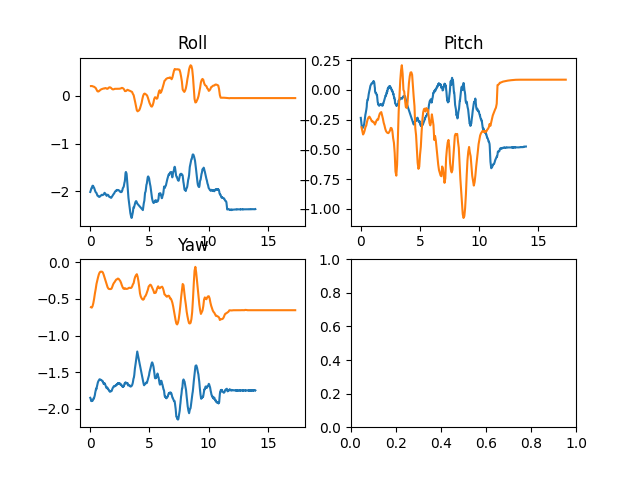

In [6]:

plot_euler(camera_df[['W_rot', 'X_rot', 'Y_rot', 'Z_rot']], imu_df[['femur_w', 'femur_x', 'femur_y', 'femur_z']], camera_df['time'], imu_df['time'])
plt.show()


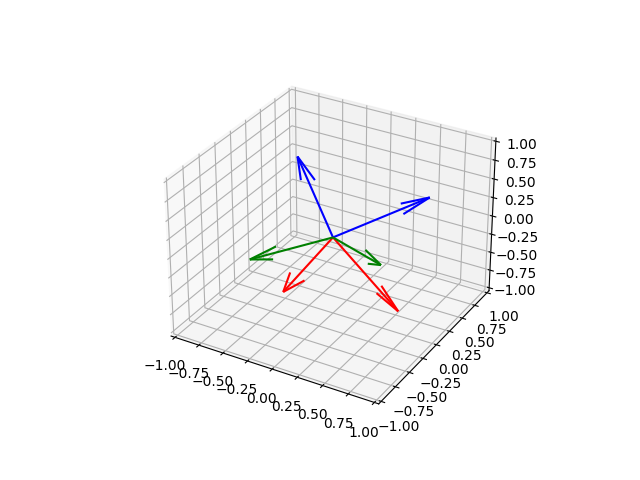

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
quaternion_visualisation(camera_df[['W_rot', 'X_rot', 'Y_rot', 'Z_rot']].iloc[0].values, ax=ax, colour='r')
quaternion_visualisation(imu_df[['femur_w', 'femur_x', 'femur_y', 'femur_z']].iloc[0].values, ax=ax, colour='b')
plt.show()

### Second problem: frame allignment 

Unsure of the convention of both sensors, using final resting point as a fixed calibration

In [8]:
# Change to right hand coordinates
# imu_df["femur_z"] = -imu_df["femur_z"]

In [9]:


camera_resampled = camera_df.set_index('time')
camera_resampled.index = pd.TimedeltaIndex(camera_resampled.index, unit='s')
camera_resampled = camera_resampled.resample('1ms').asfreq().ffill()

imu_resampled = imu_df.set_index('time')
imu_resampled.index = pd.TimedeltaIndex(imu_resampled.index, unit='s')
imu_resampled = imu_resampled.resample('1ms').asfreq().ffill()

# Trim end of larger dataset
if len(camera_resampled) > len(imu_resampled):
    camera_resampled = camera_resampled[:len(imu_resampled)]
else:
    imu_resampled = imu_resampled[:len(camera_resampled)]

# Print resampled data
# print(camera_resampled)
# print(imu_resampled)


In [10]:
camera_torch = torch.tensor(camera_resampled[['W_rot', 'X_rot', 'Y_rot', 'Z_rot']].values, dtype=torch.float32)
imu_torch = torch.tensor(imu_resampled[['femur_w', 'femur_x', 'femur_y', 'femur_z']].values, dtype=torch.float32)

print(camera_torch.shape)
print(imu_torch.shape)

torch.Size([13934, 4])
torch.Size([13934, 4])


In [11]:
def qmul(q, r):
    """
    Multiply quaternion(s) q with quaternion(s) r.
    Expects two equally-sized tensors of shape (*, 4), where * denotes any number of dimensions.
    Returns q*r as a tensor of shape (*, 4).
    """
    assert q.shape[-1] == 4
    assert r.shape[-1] == 4
    
    original_shape = q.shape
    
    # Compute outer product
    terms = torch.bmm(r.view(-1, 4, 1), q.view(-1, 1, 4))

    w = terms[:, 0, 0] - terms[:, 1, 1] - terms[:, 2, 2] - terms[:, 3, 3]
    x = terms[:, 0, 1] + terms[:, 1, 0] - terms[:, 2, 3] + terms[:, 3, 2]
    y = terms[:, 0, 2] + terms[:, 1, 3] + terms[:, 2, 0] - terms[:, 3, 1]
    z = terms[:, 0, 3] - terms[:, 1, 2] + terms[:, 2, 1] + terms[:, 3, 0]
    return torch.stack((w, x, y, z), dim=1).view(original_shape)



q = torch.nn.Parameter(torch.tensor([imu_resampled['femur_w'][-1], -imu_resampled['femur_x'][-1], 
                                     -imu_resampled['femur_y'][-1], -imu_resampled['femur_z'][-1]], dtype=torch.float32))
                                     
q_p = torch.tensor([camera_resampled['W_rot'][-1], camera_resampled['X_rot'][-1], 
                    camera_resampled['Y_rot'][-1], camera_resampled['Z_rot'][-1]], dtype=torch.float32)

# q = torch.nn.Parameter(torch.tensor([1.0, 0.0, 0.0, 0.0], dtype=torch.float32))

q.requires_grad = True

optimizer = torch.optim.Adam([q], lr=0.01)

# # # Optimise q*imu_torch to be close to camera_torch
# for i in range(200):
#     optimizer.zero_grad()
#     q_batch = q.view(1,4).repeat(camera_torch.shape[0], 1)
#     pred = qmul(q_batch, imu_torch)
#     loss = torch.mean((pred - camera_torch)**2)
#     loss.backward()
#     optimizer.step()
#     if i % 20 == 0:
#         print(f'Loss: {loss}')

print(f'Optimised quaternion: {q}')

# imu_torch_rotated = qmul(q.view(1,4).repeat(imu_torch.shape[0], 1), imu_torch)
imu_torch_rotated = qmul(q_p.view(1,4).repeat(imu_torch.shape[0], 1), qmul(q.view(1,4).repeat(imu_torch.shape[0], 1), imu_torch))

/tmp/ipykernel_17740/3067255499.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  q = torch.nn.Parameter(torch.tensor([imu_resampled['femur_w'][-1], -imu_resampled['femur_x'][-1],
/tmp/ipykernel_17740/3067255499.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  -imu_resampled['femur_y'][-1], -imu_resampled['femur_z'][-1]], dtype=torch.float32))
/tmp/ipykernel_17740/3067255499.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Optimised quaternion: Parameter containing:
tensor([ 0.4429, -0.0269, -0.0418,  0.8952], requires_grad=True)


           roll     pitch       yaw
0     -2.011837 -0.235129 -1.851527
1     -2.011837 -0.235129 -1.851527
2     -2.011837 -0.235129 -1.851527
3     -2.011837 -0.235129 -1.851527
4     -2.011837 -0.235129 -1.851527
...         ...       ...       ...
13929 -2.372407 -0.475374 -1.747096
13930 -2.372407 -0.475374 -1.747096
13931 -2.372407 -0.475374 -1.747096
13932 -2.372407 -0.475374 -1.747096
13933 -2.372407 -0.475374 -1.747096

[13934 rows x 3 columns]


[]

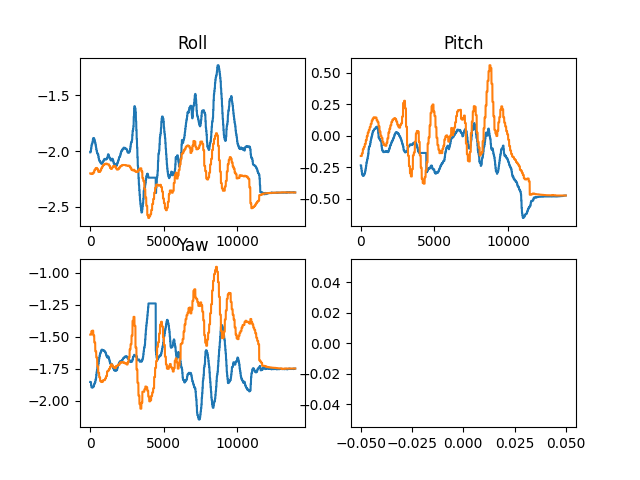

In [12]:
plot_euler(camera_torch.detach().numpy(), imu_torch_rotated.detach().numpy())
plt.plot()


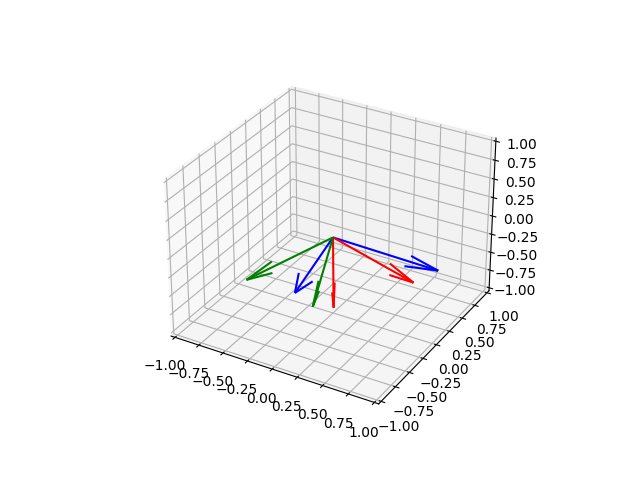

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
quaternion_visualisation(camera_torch.detach().numpy()[7000], ax=ax, colour='r')
quaternion_visualisation(imu_torch_rotated.detach().numpy()[7000], ax=ax, colour='b')
plt.show()